In [27]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px

In [28]:
# Data Preparation
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET/New_Sales_Data_Gemcon.xlsx"

try:
    sales_data = pd.read_excel(file_path)
    print("Sales data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    sales_data = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")
    sales_data = pd.DataFrame()

# Preview Raw Data 
if not sales_data.empty:
    print("\n First 5 rows of raw data:")
    display(sales_data.head())
else:
    print("\n No data to display.")

Sales data loaded successfully.

 First 5 rows of raw data:


,ds,y,Sold Value,Average Lead Time,Avg Order Frequncey,Monthly Order Qty,safety stock,Shelf Life
0,2023-01-31,555,72150,5 Days,3,1665,166,4 months
1,2023-02-28,536,69680,5 Days,3,1608,160,4 months
2,2023-03-31,545,70850,5 Days,3,1635,163,4 months
3,2023-04-30,539,70070,5 Days,3,1617,161,4 months
4,2023-05-31,545,70850,5 Days,3,1635,163,4 months


09:42:09 - cmdstanpy - INFO - Chain [1] start processing
09:42:09 - cmdstanpy - INFO - Chain [1] done processing


Peak at index 13 with value 575


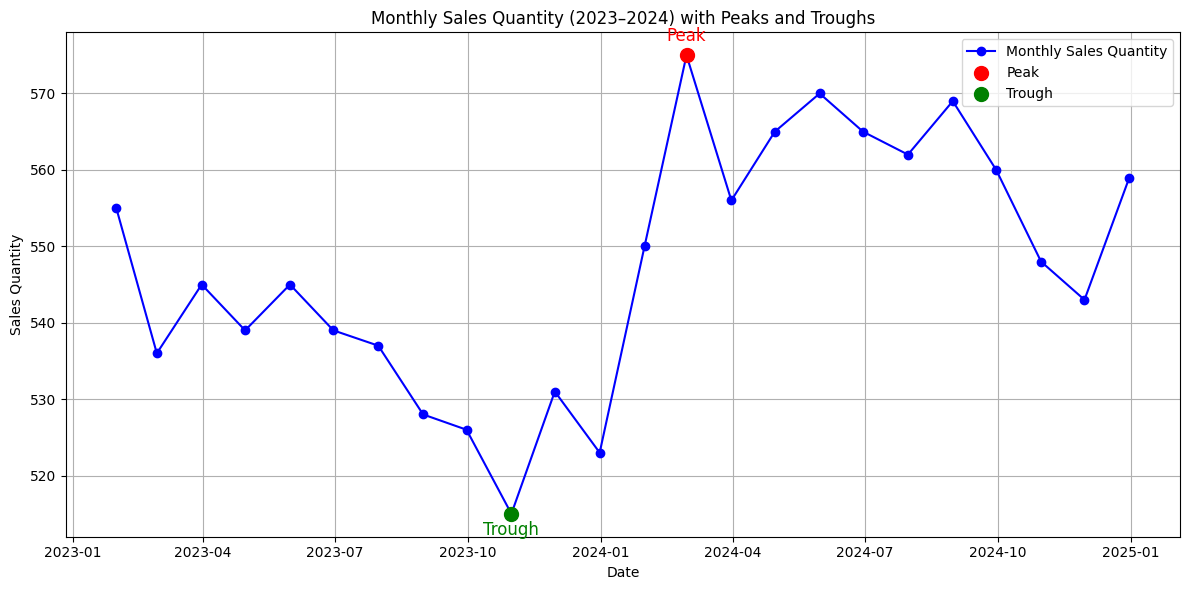

In [29]:
# Data Cleaning
df_clean = sales_data.copy()
df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean['y'] = pd.to_numeric(df_clean['y'], errors='coerce') 
      
# Line chart of monthly sales quantity (y) for 2023–2024, highlighting peaks and troughs
sales_23_24 = df_clean[(df_clean['ds'].dt.year >= 2023) & (df_clean['ds'].dt.year <= 2024)].copy()

# Identify peaks and troughs
peak_idx = sales_23_24['y'].idxmax()
trough_idx = sales_23_24['y'].idxmin()
print(f"Peak at index {peak_idx} with value {sales_23_24.loc[peak_idx, 'y']}")
# Standardize column names
sales_data.columns = sales_data.columns.str.strip()

required_cols = ['ds', 'y', 'Sold Value', 'Average Lead Time', 'Avg Order Frequncey', 'Monthly Order Qty', 'safety stock', 'Shelf Life']
missing_cols = [col for col in required_cols if col not in sales_data.columns]

# Initialize Prophet 
m = Prophet()

# Fit the model
m.fit(sales_data[['ds', 'y']])

plt.figure(figsize=(12, 6))
plt.plot(sales_23_24['ds'], sales_23_24['y'], label='Monthly Sales Quantity', color='blue', marker='o')

# Highlight peak
plt.scatter(sales_23_24.loc[peak_idx, 'ds'], sales_23_24.loc[peak_idx, 'y'], color='red', s=100, label='Peak', zorder=5)
plt.annotate('Peak', (sales_23_24.loc[peak_idx, 'ds'], sales_23_24.loc[peak_idx, 'y']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12)

# Highlight trough
plt.scatter(sales_23_24.loc[trough_idx, 'ds'], sales_23_24.loc[trough_idx, 'y'], color='green', s=100, label='Trough', zorder=5)
plt.annotate('Trough', (sales_23_24.loc[trough_idx, 'ds'], sales_23_24.loc[trough_idx, 'y']),
             textcoords="offset points", xytext=(0,-15), ha='center', color='green', fontsize=12)

plt.title('Monthly Sales Quantity (2023–2024) with Peaks and Troughs')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Clean Separate Basic Forecast Data ---
df_raw = pd.read_excel(file_path)

if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float))

df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

# Using 365 days initial training, 90 days step, 180 days forecast horizon
df_cv = cross_validation(
    m,
    initial='365 days',     # 1 year for training
    period='90 days',       # Advance by 3 months each fold
    horizon='180 days',     # Forecast 6 months ahead
    parallel="processes")

# Calculate Performance Metrics ---
df_p = performance_metrics(df_cv)

# Display Metrics
print("\nAvailable metrics:")
print(df_p.columns.tolist())

print("\nForecast Accuracy (average across folds):")
print(df_p[['horizon', 'mae', 'rmse', 'mape']])

# Calculate R² per Fold and Mean R²
r2_per_fold = df_cv.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat']))

print("\nR² per fold:")
print(r2_per_fold)
print(f"\nMean R² across folds: {r2_per_fold.mean():.4f}")


Available metrics:
['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']

Forecast Accuracy (average across folds):
    horizon        mae       rmse      mape
0   25 days   3.291237   3.291237  0.005825
1   27 days  17.339915  17.339915  0.030854
2   56 days   5.710819   5.710819  0.010019
3   58 days  16.210128  16.210128  0.028489
4   86 days  17.891060  17.891060  0.031666
5   88 days  30.890979  30.890979  0.055162
6  117 days  28.310642  28.310642  0.050375
7  119 days  48.761193  48.761193  0.088980
8  148 days  28.730224  28.730224  0.050492
9  149 days  59.442044  59.442044  0.109470
10 178 days  44.910464  44.910464  0.080197
11 180 days  49.312257  49.312257  0.088215

R² per fold:
cutoff
2024-04-05   -52.551052
2024-07-04   -20.490162
dtype: float64

Mean R² across folds: -36.5206


09:42:10 - cmdstanpy - INFO - Chain [1] start processing
09:42:10 - cmdstanpy - INFO - Chain [1] start processing
09:42:10 - cmdstanpy - INFO - Chain [1] done processing
09:42:10 - cmdstanpy - INFO - Chain [1] done processing


09:42:10 - cmdstanpy - INFO - Chain [1] start processing
09:42:17 - cmdstanpy - INFO - Chain [1] done processing


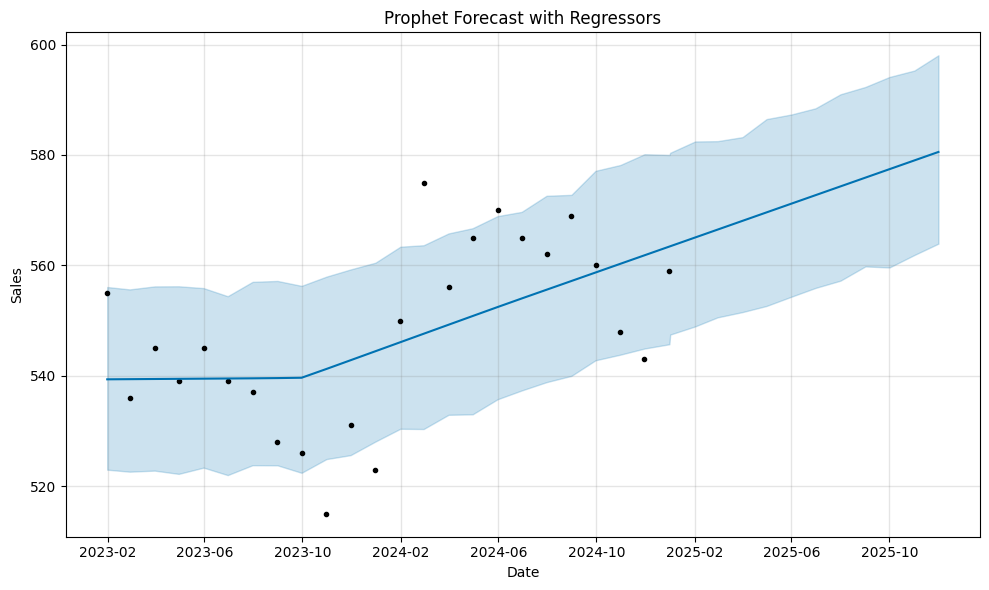

In [31]:
# Forecasting with Prophet
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

# Forecast 12 Future Months
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Extract 2025 Forecast Data
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# Define regressors 
regressors = ['Sold Value', 'Average Lead Time', 'Avg Order Frequncey', 'Monthly Order Qty', 'safety stock', 'Shelf Life']

# Merge existing regressors into the future dataframe
for reg in regressors:
    if reg not in sales_data.columns:
        sales_data[reg] = np.nan
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')

# Optional: Fill any remaining NaNs (e.g., trailing values after interpolation)
future[regressors] = future[regressors].fillna(method='ffill')

# Forecast with Prophet 
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.title("Prophet Forecast with Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

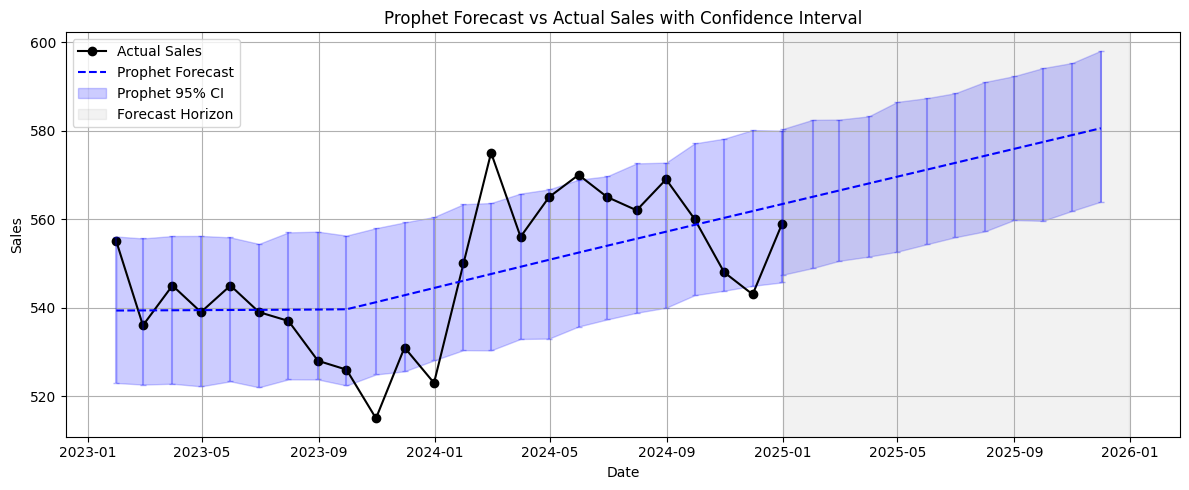

In [32]:
# Plot Setup
fig, ax = plt.subplots(figsize=(12, 5))

# Plot Actual Sales
ax.plot(df_clean['ds'], df_clean['y'], label='Actual Sales', marker='o', color='black', linewidth=1.5)

# Prophet Forecast Line
ax.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--', color='blue', linewidth=1.5)

# Prophet Confidence Interval Shading 
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Prophet 95% CI')

# Prophet Error Bars 
ax.errorbar(forecast['ds'], forecast['yhat'], yerr=[ forecast['yhat'] - forecast['yhat_lower'], forecast['yhat_upper'] - forecast['yhat']], fmt='none', ecolor='blue', alpha=0.3, capsize=2)

# Highlight Forecast Region (2025) 
ax.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'), color='gray', alpha=0.1, label='Forecast Horizon')

# Final Plot Details 
ax.set_title('Prophet Forecast vs Actual Sales with Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

In [33]:
# Bootstrapped Confidence Intervals for Prophet Forecast ---
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

n_boot = 1000
forecast_horizon = forecast_2025.shape[0]
boot_samples = np.empty((n_boot, forecast_horizon))

for i in range(n_boot):
    sampled_residuals = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_samples[i] = forecast_2025['yhat'].values + sampled_residuals

forecast_2025['boot_lower'] = np.percentile(boot_samples, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_samples, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_samples, 50, axis=0)

# Simulate Bootstrap Samples (based on boot_median) ---
np.random.seed(42)
boot_samples = pd.DataFrame(
    np.random.normal(loc=forecast_2025['boot_median'], scale=50, size=(1000, 12)).T,
    columns=[f'bs_{i}' for i in range(1000)])


 Reorder Point (ROP) Table:
           ds        yhat  boot_median  boot_upper  prophet_rop
24 2025-01-01  572.267734   571.821994  599.658665        600.0
25 2025-02-01  500.300041   501.599373  527.690972        528.0
26 2025-03-01  637.883630   637.437890  665.274561        665.0
27 2025-04-01  575.776004   575.330264  603.166935        603.0
28 2025-05-01  582.612066   583.911398  610.002997        610.0
29 2025-06-01  586.142481   587.441813  613.533412        614.0
30 2025-07-01  582.398432   583.697763  609.789363        610.0
31 2025-08-01  578.906133   580.205465  606.297064        606.0
32 2025-09-01  602.186408   601.740668  629.577339        630.0
33 2025-10-01  587.715443   587.269703  615.106374        615.0
34 2025-11-01  575.759046   575.313306  603.149977        603.0
35 2025-12-01  549.972493   549.526753  577.363424        577.0


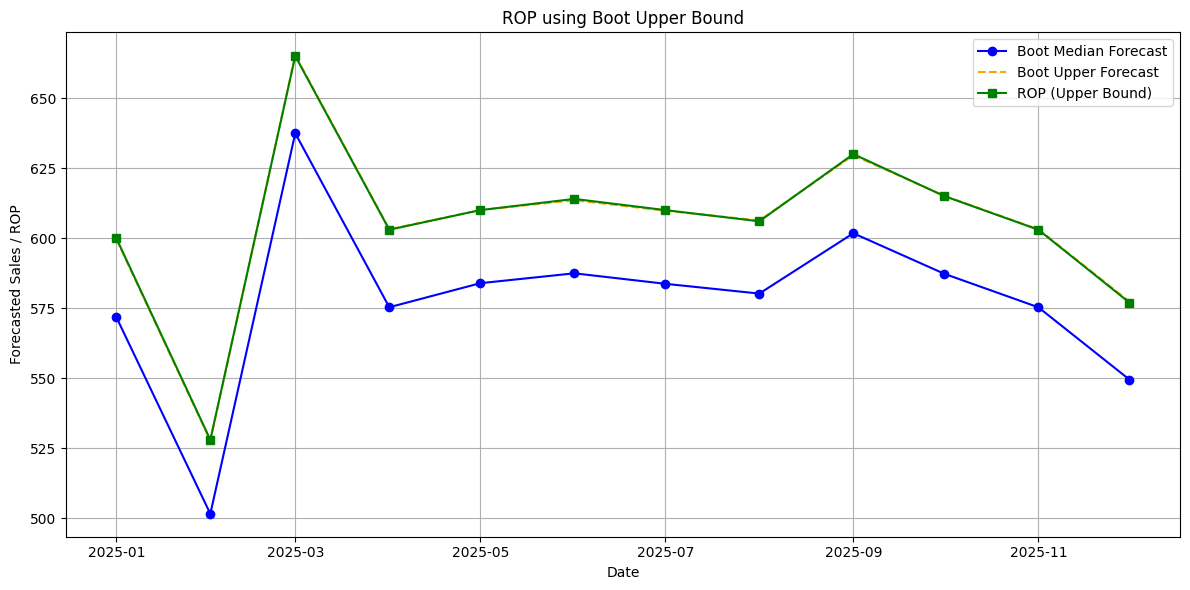

In [34]:
# Dynamic Reorder Point (ROP) Calculation
k = 1.0 
forecast_2025['prophet_rop'] = (forecast_2025['boot_median'] + k * (forecast_2025['boot_upper'] - forecast_2025['boot_median'])
).round().clip(lower=0)

# Output Table 
print("\n Reorder Point (ROP) Table:")
print(forecast_2025[['ds', 'yhat', 'boot_median', 'boot_upper', 'prophet_rop']])

# Plot 1: Prophet ROP based on upper bound ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Boot Median Forecast', marker='o', color='blue')
plt.plot(forecast_2025['ds'], forecast_2025['boot_upper'], label='Boot Upper Forecast', linestyle='--', color='orange')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='ROP (Upper Bound)', marker='s', color='green')
plt.title("ROP using Boot Upper Bound")
plt.xlabel("Date")
plt.ylabel("Forecasted Sales / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Residual Modeling with ARIMA
df_with_yhat = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='left')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']

arima_model = ARIMA(df_with_yhat['residual'].dropna(), order=(1, 0, 1)).fit()

arima_forecast = arima_model.forecast(steps=12)
final_forecast = forecast.tail(12).copy()
final_forecast['arima_correction'] = arima_forecast.values
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + final_forecast['arima_correction']

merged_df = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
actual = merged_df['y'].values
prophet_pred = merged_df['yhat'].values

arima_correction_hist = arima_model.predict(start=0, end=len(actual) - 1)
arophet_pred = prophet_pred + arima_correction_hist


2025 Forecast and ROP Table:
           ds        yhat  arima_correction  yhat_hybrid  arophet_rop
0  2025-01-01  563.457015         -2.563299   560.893715   554.494463
1  2025-02-01  565.042464         -1.282321   563.760143   557.360890
2  2025-03-01  566.474482         -0.533617   565.940865   559.541612
3  2025-04-01  568.059931         -0.096017   567.963914   561.564662
4  2025-05-01  569.594236          0.159751   569.753988   563.354735
5  2025-06-01  571.179685          0.309242   571.488927   565.089675
6  2025-07-01  572.713991          0.396616   573.110607   566.711354
7  2025-08-01  574.299440          0.447684   574.747124   568.347871
8  2025-09-01  575.884888          0.477533   576.362421   569.963169
9  2025-10-01  577.419194          0.494978   577.914172   571.514920
10 2025-11-01  579.004643          0.505175   579.509818   573.110565
11 2025-12-01  580.538948          0.511135   581.050083   574.650830


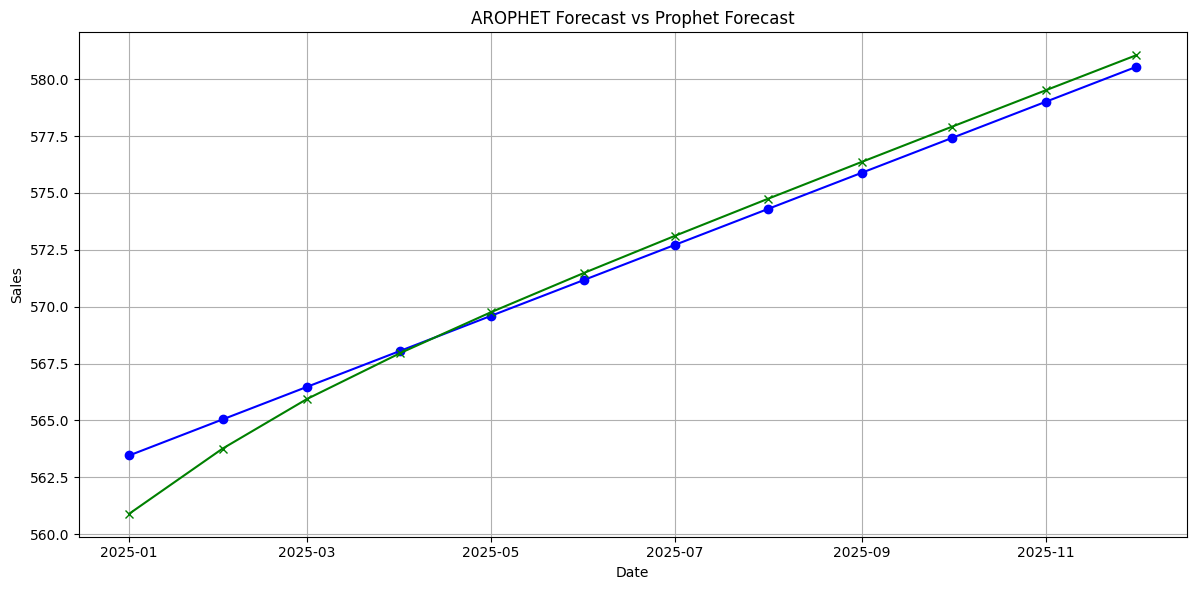

In [36]:
# Hybrid Forecast Using AROPHET
forecast_2025 = final_forecast[final_forecast['ds'].dt.year == 2025].copy()

if 'yhat_hybrid' in forecast_2025.columns:
    forecast_2025 = forecast_2025.drop(columns=['yhat_hybrid'])

forecast_2025 = forecast_2025.merge(
    final_forecast[['ds', 'yhat_hybrid']], on='ds', how='left')

# Final Dynamic ROP Using AROPHET
k = 1.0 
forecast_2025['prophet_rop'] = forecast_2025['yhat'] - k * (forecast_2025['yhat_upper'] - forecast_2025['yhat'])
hybrid_std = forecast_2025['yhat_hybrid'].std()
forecast_2025['arophet_median'] = forecast_2025['yhat_hybrid']
forecast_2025['arophet_rop'] = forecast_2025['yhat_hybrid'] - k * hybrid_std

# Output Table for AROPHET ROP
print("\n2025 Forecast and ROP Table:")
print(forecast_2025[['ds', 'yhat','arima_correction', 'yhat_hybrid', 'arophet_rop']])

plt.figure(figsize=(12, 6))
plt.title("AROPHET Forecast vs Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()      
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], label='Prophet Forecast', marker='o', color='blue')
plt.plot(forecast_2025['ds'], forecast_2025['yhat_hybrid'], label='AROPHET Forecast', marker='x', color='green')                                         

ROP Comparison Table (Prophet vs AROPHET):
         Date  Prophet_ROP  AROPHET_ROP
0  2025-01-01   546.525053   554.494463
1  2025-02-01   547.646427   557.360890
2  2025-03-01   550.453115   559.541612
3  2025-04-01   552.898314   561.564662
4  2025-05-01   552.696011   563.354735
5  2025-06-01   555.031332   565.089675
6  2025-07-01   556.978575   566.711354
7  2025-08-01   557.615161   568.347871
8  2025-09-01   559.457919   569.963169
9  2025-10-01   560.720041   571.514920
10 2025-11-01   562.727254   573.110565
11 2025-12-01   563.024327   574.650830


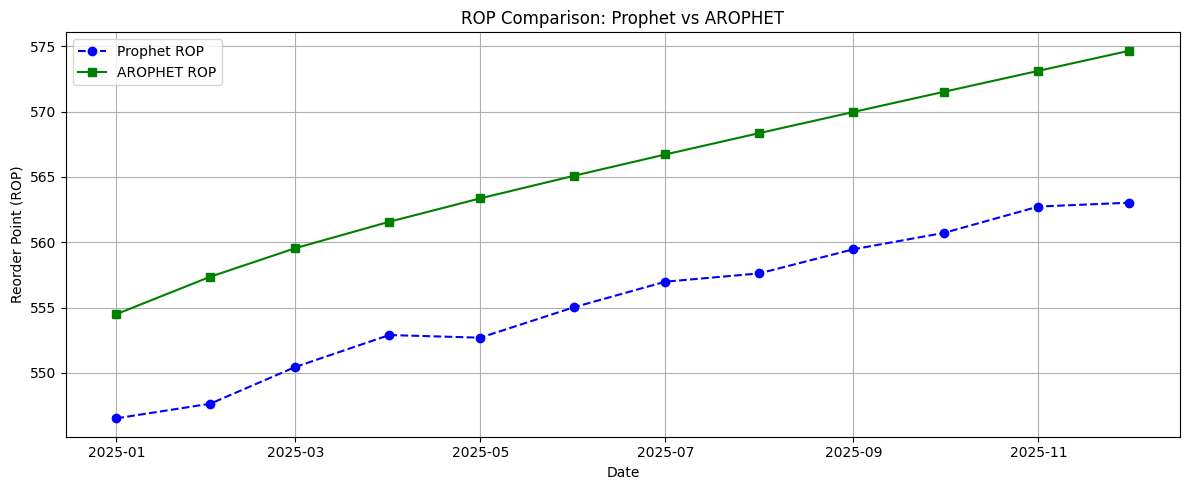

In [37]:
# ROP Comparison Table: Prophet vs AROPHET
if 'forecast_2025' in globals():
	rop_comparison = forecast_2025[['ds', 'prophet_rop', 'arophet_rop']].copy()
	rop_comparison.columns = ['Date', 'Prophet_ROP', 'AROPHET_ROP']
	print("ROP Comparison Table (Prophet vs AROPHET):")
	print(rop_comparison)
else:
	print("Error: 'forecast_2025' is not defined. Please run the previous cells that generate 'forecast_2025'.")

# ROP Comparision: (Prophet vs AROPHET)
plt.figure(figsize=(12, 5))
plt.plot(
    forecast_2025['ds'],
    forecast_2025['prophet_rop'],
    label='Prophet ROP',
    linestyle='--',
    marker='o',
    color='blue')

plt.plot(
    forecast_2025['ds'],
    forecast_2025['arophet_rop'],
    label='AROPHET ROP',
    linestyle='-',
    marker='s',
    color='green')

plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('Reorder Point (ROP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd

# Actual sales data provided by the user
actual_sales_2025 = np.array([565, 568, 577, 579, 575, 569, 565, 548])

# Extract the corresponding forecast data from forecast_2025
forecast_prophet_2025 = forecast_2025['yhat'].values[:len(actual_sales_2025)]
forecast_arophet_2025 = forecast_2025['yhat_hybrid'].values[:len(actual_sales_2025)]
dates_2025 = forecast_2025['ds'].dt.strftime('%Y-%m-%d').values[:len(actual_sales_2025)]

# Create a DataFrame for comparison
comparison_table = pd.DataFrame({
    'Date': dates_2025,
    'Actual Sales': actual_sales_2025,
    'Prophet Forecast': forecast_prophet_2025,
    'Prophet Error': actual_sales_2025 - forecast_prophet_2025,
    'AROPHET Forecast': forecast_arophet_2025,
    'AROPHET Error': actual_sales_2025 - forecast_arophet_2025
})

print("Forecast Comparison Table (Jan-Aug 2025) with Errors:")
display(comparison_table)

Forecast Comparison Table (Jan-Aug 2025) with Errors:


,Date,Actual Sales,Prophet Forecast,Prophet Error,AROPHET Forecast,AROPHET Error
0,2025-01-01,565,563.457015,1.542985,560.893715,4.106285
1,2025-02-01,568,565.042464,2.957536,563.760143,4.239857
2,2025-03-01,577,566.474482,10.525518,565.940865,11.059135
3,2025-04-01,579,568.059931,10.940069,567.963914,11.036086
4,2025-05-01,575,569.594236,5.405764,569.753988,5.246012
5,2025-06-01,569,571.179685,-2.179685,571.488927,-2.488927
6,2025-07-01,565,572.713991,-7.713991,573.110607,-8.110607
7,2025-08-01,548,574.299440,-26.299440,574.747124,-26.747124
